# Transportation Examples


![image](../figures/transportation.png)

## 01-Transportation example 1

In [1]:
# Basic Transportation model 

import simpy 
import numpy as np

def compute_distance(from_node, to_node):
    return np.sqrt((from_node.x-to_node.x)**2 + (from_node.y-to_node.y)**2)


class DemandNode():
    def __init__(self, env, id, x, y):
        self.env = env
        self.id = id
        self.x = x
        self.y = y

        self.unloaded_vehicles = 0

        self.entry_queu = []

    def on_entered(self, vehicle):
        print(f"{self.env.now:.2f} - Vehicle {vehicle.id} entered on node {self.id} - type {type(self).__name__}")
        self.entry_queu.append(vehicle)
        yield self.env.timeout(1)

    def process_vehicle(self, vehicle):
        yield self.env.timeout(np.random.uniform(5,10))
        self.unloaded_vehicles = self.unloaded_vehicles+1
        vehicle.loaded = False
        return vehicle

    def on_exited(self, vehicle):
        print(f"{self.env.now:.2f} - Vehicle {vehicle.id} exited from node {self.id} - type {type(self).__name__}")
        yield self.env.timeout(1)

    def __call__(self):
        while True:
            if len(self.entry_queu)>0:
                vehicle = self.entry_queu[0]
                vehicle = yield self.env.process(self.process_vehicle(vehicle))
                self.entry_queu.remove(vehicle)
                vehicle.idle = True
            else:
                yield self.env.timeout(1)


class SourceNode():
    def __init__(self, env, id, x, y):
        self.env = env
        self.id = id
        self.x = x
        self.y = y
    
        self.loaded_vehicles = 0

        self.entry_queu = []

    def on_entered(self, vehicle):
        print(f"{self.env.now:.2f} - Vehicle {vehicle.id} entered on node {self.id} - type {type(self).__name__}")
        self.entry_queu.append(vehicle)
        yield self.env.timeout(1)

    def process_vehicle(self, vehicle):
        yield self.env.timeout(np.random.uniform(5,10))
        self.loaded_vehicles = self.loaded_vehicles+1
        vehicle.loaded = True
        return vehicle


    def on_exited(self, vehicle):
        print(f"{self.env.now:.2f} - Vehicle {vehicle.id} exited from node {self.id} - type {type(self).__name__}")
        yield self.env.timeout(1)

    def __call__(self):
        while True:
            if len(self.entry_queu)>0:
                vehicle = self.entry_queu[0]
                vehicle = yield self.env.process(self.process_vehicle(vehicle))
                self.entry_queu.remove(vehicle)
                vehicle.idle = True
            else:
                yield self.env.timeout(1)


class Vehicle():
    
    def __init__(
            self, 
            env:simpy.Environment, 
            id:int, 
            current_node,
            speed:float=1., 
            ):

        self.env = env
        self.id = id
        self.current_node = current_node
        self.speed = speed # km/hs
        self.loaded = True
        self.idle = True
        self.content = []
        

    def move(self, to_node):
        dist = compute_distance(self.current_node,to_node) # km
        yield self.env.process(self.current_node.on_exited(self))
        yield self.env.timeout(dist/self.speed)
        self.current_node = to_node
        yield self.env.process(self.current_node.on_entered(self))
        

class Router():

    def __init__(self, env, nodes, vehicles):
        self.env = env
        self.nodes = nodes
        self.vehicles = vehicles

        self.source_nodes = [n for n in nodes if isinstance(n, SourceNode)]
        self.demand_nodes = [n for n in nodes if isinstance(n, DemandNode)]

    def __call__(self):
        while True:
            for vehicle in self.vehicles:
                if vehicle.idle and vehicle.loaded:
                    idx_to_node = np.random.choice(len(self.demand_nodes))
                    vehicle.idle = False
                    yield self.env.process(vehicle.move(self.demand_nodes[idx_to_node]))
                elif vehicle.idle and not vehicle.loaded:
                    idx_to_node = np.random.choice(len(self.source_nodes))
                    vehicle.idle = False
                    yield self.env.process(vehicle.move(self.source_nodes[idx_to_node]))
                else:
                    yield self.env.timeout(1)
                


env = simpy.Environment()
source_node = SourceNode(env, id=0, x=0, y=0)
demand_node = DemandNode(env, id=0, x=10, y=10)
vehicle = Vehicle(env,id=0, current_node=source_node)
router  = Router(env, nodes=[source_node,demand_node], vehicles = [vehicle])

env.process(source_node()) # Espera a recibir vehiculos
env.process(demand_node()) # Espera a recibir vehiculos
env.process(router()) # Manda vehiculos a source o demand nodes

env.run(until=1000)


0.00 - Vehicle 0 exited from node 0 - type SourceNode
15.14 - Vehicle 0 entered on node 0 - type DemandNode
22.14 - Vehicle 0 exited from node 0 - type DemandNode
37.28 - Vehicle 0 entered on node 0 - type SourceNode
44.28 - Vehicle 0 exited from node 0 - type SourceNode
59.43 - Vehicle 0 entered on node 0 - type DemandNode
69.43 - Vehicle 0 exited from node 0 - type DemandNode
84.57 - Vehicle 0 entered on node 0 - type SourceNode
94.57 - Vehicle 0 exited from node 0 - type SourceNode
109.71 - Vehicle 0 entered on node 0 - type DemandNode
116.71 - Vehicle 0 exited from node 0 - type DemandNode
131.85 - Vehicle 0 entered on node 0 - type SourceNode
140.85 - Vehicle 0 exited from node 0 - type SourceNode
155.99 - Vehicle 0 entered on node 0 - type DemandNode
164.99 - Vehicle 0 exited from node 0 - type DemandNode
180.14 - Vehicle 0 entered on node 0 - type SourceNode
189.14 - Vehicle 0 exited from node 0 - type SourceNode
204.28 - Vehicle 0 entered on node 0 - type DemandNode
210.28 - Ve

In [2]:
print("Total Unloaded Vehicles in demand node: ",demand_node.unloaded_vehicles)
print("Total Loaded Vehicles in source node: ",source_node.loaded_vehicles)

Total Unloaded Vehicles in demand node:  21
Total Loaded Vehicles in source node:  21


## 02-Transportation Example 2 

In [3]:
import datetime
import simpy 
import numpy as np
import matplotlib.pyplot as plt
import os


    
class Clock():
    def __init__(self, env, start_date=None):
        self.env = env
        self.start_date = (
            start_date if start_date 
            else datetime.datetime.now()
            ) 

    @property
    def current_date(self):
        return (
            datetime.timedelta(seconds = self.env.now) + 
            self.start_date
            )


def compute_distance(from_node, to_node):
    return np.sqrt((from_node.x-to_node.x)**2 + (from_node.y-to_node.y)**2)


class DemandNode():
    def __init__(self, env, clock, id, x, y):
        self.env = env
        self.clock = clock
        self.id = id
        self.x = x
        self.y = y

        self.unloaded_vehicles = 0
        self.entry_queu = []


    def on_entered(self, vehicle):
        print(f"{self.clock.current_date} - Vehicle {vehicle.id} entered on node {type(self).__name__}-{self.id}")
        self.entry_queu.append(vehicle)
        yield self.env.timeout(1)

    def process_vehicle(self, vehicle):
        print(f"{self.clock.current_date} - Vehicle {vehicle.id} processing on node {type(self).__name__}-{self.id}")
        yield self.env.process(vehicle.unload())
        self.unloaded_vehicles = self.unloaded_vehicles+1
        vehicle.loaded = False
        return vehicle

    def on_exited(self, vehicle):
        print(f"{self.clock.current_date} - Vehicle {vehicle.id} exited from node {type(self).__name__}-{self.id}")

        yield self.env.timeout(1)

    def __call__(self):
        while True:
            if len(self.entry_queu)>0:
                vehicle = self.entry_queu[0]
                vehicle = yield self.env.process(self.process_vehicle(vehicle))
                self.entry_queu.remove(vehicle)
                vehicle.idle = True
            else:
                yield self.env.timeout(1)


class SourceNode():
    def __init__(self, env, clock, id, x, y):
        self.env = env
        self.clock = clock
        self.id = id
        self.x = x
        self.y = y
    
        self.loaded_vehicles = 0

        self.entry_queu = []

    def on_entered(self, vehicle):
        print(f"{self.clock.current_date} - Vehicle {vehicle.id} entered on node {type(self).__name__}-{self.id}")
        self.entry_queu.append(vehicle)
        yield self.env.timeout(1)

    def process_vehicle(self, vehicle):
        print(f"{self.clock.current_date} - Vehicle {vehicle.id} start processing on node {type(self).__name__}-{self.id}")
        yield self.env.process(vehicle.load())
        print(f"{self.clock.current_date} - Vehicle {vehicle.id} end processing on node {type(self).__name__}-{self.id}")
        self.loaded_vehicles = self.loaded_vehicles+1
        vehicle.loaded = True
        return vehicle

    def on_exited(self, vehicle):
        print(f"{self.clock.current_date} - Vehicle {vehicle.id} exited from node {type(self).__name__}-{self.id}")
        yield self.env.timeout(1)

    def __call__(self):
        while True:
            if len(self.entry_queu)>0:
                vehicle = self.entry_queu[0]
                vehicle = yield self.env.process(self.process_vehicle(vehicle))
                self.entry_queu.remove(vehicle)
                vehicle.idle = True
            else:
                yield self.env.timeout(1)


class Vehicle():
    
    def __init__(
            self, 
            env:simpy.Environment, 
            clock:Clock, 
            id:int, 
            current_node,
            speed:float=100., # km/hs
            load_time:float=5, # minutes
            unload_time:float=5 # minutes
            ):

        self.env = env
        self.clock = clock
        self.id = id
        self.current_node = current_node
        self.speed = speed/(60*60) # convert km/hs to km/s
        self.load_time = load_time*60
        self.unload_time = unload_time*60
        self.loaded = True
        self.idle = True
        self.content = []
        

    def move(self, to_node):
        yield self.env.process(self.current_node.on_exited(self))

        print(f"{self.clock.current_date} - {type(self).__name__}-{self.id} - moving from {type(self.current_node).__name__}-{self.current_node.id} to {type(to_node).__name__}-{to_node.id}")
        dist = compute_distance(self.current_node,to_node) # km
        yield self.env.timeout(dist/self.speed)
        self.current_node = to_node

        yield self.env.process(self.current_node.on_entered(self))
        
    def load(self):
        yield self.env.timeout(self.load_time)

    def unload(self):
        yield self.env.timeout(self.unload_time)



class Router():

    def __init__(self, env, clock, nodes, vehicles):
        self.env = env
        self.clock = clock
        self.nodes = nodes
        self.vehicles = vehicles

        self.source_nodes = [n for n in nodes if isinstance(n, SourceNode)]
        self.demand_nodes = [n for n in nodes if isinstance(n, DemandNode)]


    def __call__(self):
        while True:
            for vehicle in self.vehicles:
                if vehicle.idle and vehicle.loaded:
                    idx_to_node = np.random.choice(len(self.demand_nodes))
                    vehicle.idle = False
                    self.env.process(vehicle.move(self.demand_nodes[idx_to_node]))
                    yield self.env.timeout(0.1)
                elif vehicle.idle and not vehicle.loaded:
                    idx_to_node = np.random.choice(len(self.source_nodes))
                    vehicle.idle = False
                    self.env.process(vehicle.move(self.source_nodes[idx_to_node]))
                    yield self.env.timeout(0.1)
                else:
                    yield self.env.timeout(0.1)    



class Monitor():

    def __init__(self, clock):
        self.clock = clock
        self.metrics = {}

    def add_metric(self, name, unit=None, initial_value=None):
        self.metrics[name] = {
            "unit":unit,
            "name":name,
            "values":[{
                "time":self.clock.current_date,
                "value":initial_value
            }]
        }

    def record_metric(self, name, value):
        self.metrics[name]['values'].append = {
                "time":self.clock.current_date,
                "value":value
        }



env = simpy.Environment()
clock = Clock(env)
monitor = Monitor(clock)


# Basic Transportation model 
source_node = SourceNode(env, clock, id=0, x=0, y=0)

n_demand_nodes = 10
demand_nodes = [
    DemandNode(env, clock, id=i, x=np.random.uniform(-10,10), y=np.random.uniform(-10,10)) 
    for i in range(n_demand_nodes)
    ] 

nodes = demand_nodes + [source_node]

n_vehicles = 1
vehicles = [Vehicle(env, clock, id=i, current_node=source_node) for i in range(n_vehicles)]

router  = Router(env, clock, nodes=nodes, vehicles = vehicles)

for n in nodes:
    env.process(n())
env.process(router())

sim_time = 1*24*60*60 # days*hours*minutes*seconds
env.run(until=sim_time)


2022-07-07 12:15:50.553086 - Vehicle 0 exited from node SourceNode-0
2022-07-07 12:15:51.553086 - Vehicle-0 - moving from SourceNode-0 to DemandNode-3
2022-07-07 12:19:32.898105 - Vehicle 0 entered on node DemandNode-3
2022-07-07 12:19:33.553086 - Vehicle 0 processing on node DemandNode-3
2022-07-07 12:24:33.553086 - Vehicle 0 exited from node DemandNode-3
2022-07-07 12:24:34.553086 - Vehicle-0 - moving from DemandNode-3 to SourceNode-0
2022-07-07 12:28:15.898105 - Vehicle 0 entered on node SourceNode-0
2022-07-07 12:28:16.553086 - Vehicle 0 start processing on node SourceNode-0
2022-07-07 12:33:16.553086 - Vehicle 0 end processing on node SourceNode-0
2022-07-07 12:33:16.553086 - Vehicle 0 exited from node SourceNode-0
2022-07-07 12:33:17.553086 - Vehicle-0 - moving from SourceNode-0 to DemandNode-7
2022-07-07 12:35:30.174232 - Vehicle 0 entered on node DemandNode-7
2022-07-07 12:35:30.553086 - Vehicle 0 processing on node DemandNode-7
2022-07-07 12:40:30.653086 - Vehicle 0 exited fro

In [4]:
def plot_nodes(demand_nodes, source_node):
    plt.figure()
    plt.scatter(
        [n.x for n in demand_nodes],
        [n.y for n in demand_nodes], 
        label='demand nodes'
        )
    plt.scatter([source_node.x],[source_node.y], label='source node')
    plt.legend()
    plt.title("Nodes")
    plt.show()


def plot_unloads(demand_nodes):
    plt.figure()
    plt.bar(
        [n.id for n in demand_nodes], 
        [n.unloaded_vehicles for n in demand_nodes], 
        label='unloaded vehicles'
        )
    plt.legend()
    plt.show()



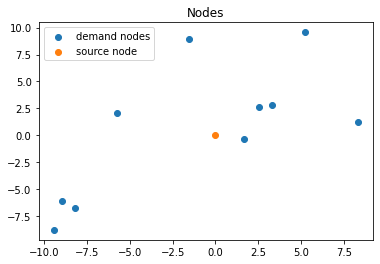

In [5]:
plot_nodes(demand_nodes, source_node)

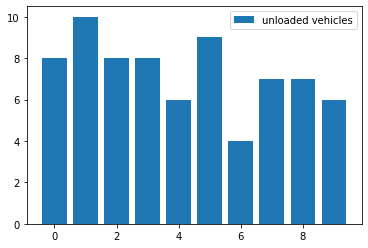

In [6]:
plot_unloads(demand_nodes)

## 03-Transportation example 3

In [7]:
# transportation example 3
import datetime
import simpy 
import numpy as np
import pandas as pd



class SimEnv(simpy.Environment):

    def __init__(self, start_date=None):
        super().__init__()

        self.start_date = (
            start_date if start_date 
            else datetime.datetime.now()
            ) 

        self.metrics = {}

    @property
    def current_date(self):
        return (
            datetime.timedelta(seconds = self.now) + 
            self.start_date
            )


    def add_metric(self, name, unit=None):
        self.metrics[name] = {
            "unit":unit,
            "name":name,
            "values":[]
        }

    def record_metric(self, name, value):
        self.metrics[name]['values'].append(value)


def compute_distance(from_node, to_node):
    return np.sqrt((from_node.x-to_node.x)**2 + (from_node.y-to_node.y)**2)


class DemandNode():
    def __init__(self, env:SimEnv, id, x, y):
        self.env = env
        self.id = id
        self.x = x
        self.y = y

        self.unloaded_vehicles = 0
        self.entry_queu = []

    def on_entered(self, vehicle):
        print(f"{self.env.current_date} - Vehicle-{vehicle.id} entered on node {type(self).__name__}-{self.id}")
        self.entry_queu.append(vehicle)

        self.env.record_metric(name='entry_queu', value={
            "node":f"{type(self).__name__}-{self.id}",
            "queu":len(self.entry_queu),
            "time":self.env.current_date
            })

        self.env.record_metric(name='queu_time', value={
            "node":f"{type(self).__name__}-{self.id}",
            "vehicle":f"{type(vehicle).__name__}-{vehicle.id}",
            "action":"entered",
            "time":self.env.current_date
            })

        yield self.env.timeout(1)

    def process_vehicle(self, vehicle):
        print(f"{self.env.current_date} - Vehicle-{vehicle.id} processing on node {type(self).__name__}-{self.id}")
        yield self.env.process(vehicle.unload())
        self.unloaded_vehicles = self.unloaded_vehicles+1
        vehicle.loaded = False
        return vehicle

    def on_exited(self, vehicle):
        print(f"{self.env.current_date} - Vehicle-{vehicle.id} exited from node {type(self).__name__}-{self.id}")
        yield self.env.timeout(1)

    def __call__(self):
        while True:
            if len(self.entry_queu)>0:
                vehicle = self.entry_queu[0]

                self.env.record_metric(name='queu_time', value={
                    "node":f"{type(self).__name__}-{self.id}",
                    "vehicle":f"{type(vehicle).__name__}-{vehicle.id}",
                    "action":"exited",
                    "time":self.env.current_date
                    })

                vehicle = yield self.env.process(self.process_vehicle(vehicle))
                self.entry_queu.remove(vehicle)
                vehicle.idle = True
            else:
                yield self.env.timeout(1)


class SourceNode():
    def __init__(self, env, id, x, y):
        self.env = env
        self.id = id
        self.x = x
        self.y = y
    
        self.loaded_vehicles = 0

        self.entry_queu = []

    def on_entered(self, vehicle):
        print(f"{self.env.current_date} - Vehicle-{vehicle.id} entered on node {type(self).__name__}-{self.id}")
        self.entry_queu.append(vehicle)

        self.env.record_metric(name='entry_queu', value={
            "node":f"{type(self).__name__}-{self.id}",
            "queu":len(self.entry_queu),
            "time":self.env.current_date
            })

        self.env.record_metric(name='queu_time', value={
            "node":f"{type(self).__name__}-{self.id}",
            "vehicle":f"{type(vehicle).__name__}-{vehicle.id}",
            "action":"entered",
            "time":self.env.current_date
            })

        yield self.env.timeout(1)

    def process_vehicle(self, vehicle):
        print(f"{self.env.current_date} - Vehicle-{vehicle.id} start processing on node {type(self).__name__}-{self.id}")
        yield self.env.process(vehicle.load())
        print(f"{self.env.current_date} - Vehicle-{vehicle.id} end processing on node {type(self).__name__}-{self.id}")
        self.loaded_vehicles = self.loaded_vehicles+1
        vehicle.loaded = True
        return vehicle

    def on_exited(self, vehicle):
        print(f"{self.env.current_date} - Vehicle-{vehicle.id} exited from node {type(self).__name__}-{self.id}")
        yield self.env.timeout(1)

    def __call__(self):
        while True:
            if len(self.entry_queu)>0:
                vehicle = self.entry_queu[0]

                self.env.record_metric(name='queu_time', value={
                    "node":f"{type(self).__name__}-{self.id}",
                    "vehicle":f"{type(vehicle).__name__}-{vehicle.id}",
                    "action":"exited",
                    "time":self.env.current_date
                    })

                vehicle = yield self.env.process(self.process_vehicle(vehicle))
                self.entry_queu.remove(vehicle)
                vehicle.idle = True
            else:
                yield self.env.timeout(1)


class Vehicle():
    
    def __init__(
            self, 
            env:SimEnv, 
            id:int, 
            current_node,
            speed:float=100., # km/hs
            load_time:float=5, # minutes
            unload_time:float=5 # minutes
            ):

        self.env = env
        self.id = id
        self.current_node = current_node
        self.speed = speed/(60*60) # convert km/hs to km/s
        self.load_time = load_time*60
        self.unload_time = unload_time*60
        self.loaded = True
        self.idle = True
        self.content = []        

        self.enter_queu_time = None
        self.exit_queu_time = None


    def move(self, to_node):
        yield self.env.process(self.current_node.on_exited(self))

        print(f"{self.env.current_date} - {type(self).__name__}-{self.id} - moving from {type(self.current_node).__name__}-{self.current_node.id} to {type(to_node).__name__}-{to_node.id}")
        dist = compute_distance(self.current_node,to_node) # km
        yield self.env.timeout(dist/self.speed)
        self.current_node = to_node

        yield self.env.process(self.current_node.on_entered(self))

        
    def load(self):
        yield self.env.timeout(self.load_time)

    def unload(self):
        yield self.env.timeout(self.unload_time)



class Router():

    def __init__(self, env, nodes, vehicles):
        self.env = env
        self.nodes = nodes
        self.vehicles = vehicles

        self.source_nodes = [n for n in nodes if isinstance(n, SourceNode)]
        self.demand_nodes = [n for n in nodes if isinstance(n, DemandNode)]


    def __call__(self):
        while True:
            for vehicle in self.vehicles:
                if vehicle.idle and vehicle.loaded:
                    idx_to_node = np.random.choice(len(self.demand_nodes))
                    vehicle.idle = False
                    self.env.process(vehicle.move(self.demand_nodes[idx_to_node]))
                    yield self.env.timeout(0.1)
                elif vehicle.idle and not vehicle.loaded:
                    idx_to_node = np.random.choice(len(self.source_nodes))
                    vehicle.idle = False
                    self.env.process(vehicle.move(self.source_nodes[idx_to_node]))
                    yield self.env.timeout(0.1)
                else:
                    yield self.env.timeout(0.1)    




env = SimEnv()
env.add_metric(name='entry_queu', unit="vehicles")
env.add_metric(name='queu_time', unit="seconds")

# Basic Transportation model 
source_node = SourceNode(env, id=0, x=0, y=0)

n_demand_nodes = 5
demand_nodes = [
    DemandNode(env, id=i, x=np.random.uniform(-10,10), y=np.random.uniform(-10,10)) 
    for i in range(n_demand_nodes)
    ] 

nodes = demand_nodes + [source_node]

n_vehicles = 10
vehicles = [Vehicle(env, id=i, current_node=source_node) for i in range(n_vehicles)]

router  = Router(env, nodes=nodes, vehicles = vehicles)

for n in nodes:
    env.process(n())
env.process(router())

sim_time = 10*24*60*60 # days*hours*minutes*seconds
env.run(until=sim_time)


2022-07-07 12:16:33.853199 - Vehicle-0 exited from node SourceNode-0
2022-07-07 12:16:33.953199 - Vehicle-1 exited from node SourceNode-0
2022-07-07 12:16:34.053199 - Vehicle-2 exited from node SourceNode-0
2022-07-07 12:16:34.153199 - Vehicle-3 exited from node SourceNode-0
2022-07-07 12:16:34.253199 - Vehicle-4 exited from node SourceNode-0
2022-07-07 12:16:34.353199 - Vehicle-5 exited from node SourceNode-0
2022-07-07 12:16:34.453199 - Vehicle-6 exited from node SourceNode-0
2022-07-07 12:16:34.553199 - Vehicle-7 exited from node SourceNode-0
2022-07-07 12:16:34.653199 - Vehicle-8 exited from node SourceNode-0
2022-07-07 12:16:34.753199 - Vehicle-9 exited from node SourceNode-0
2022-07-07 12:16:34.853199 - Vehicle-0 - moving from SourceNode-0 to DemandNode-1
2022-07-07 12:16:34.953199 - Vehicle-1 - moving from SourceNode-0 to DemandNode-3
2022-07-07 12:16:35.053199 - Vehicle-2 - moving from SourceNode-0 to DemandNode-2
2022-07-07 12:16:35.153199 - Vehicle-3 - moving from SourceNode-

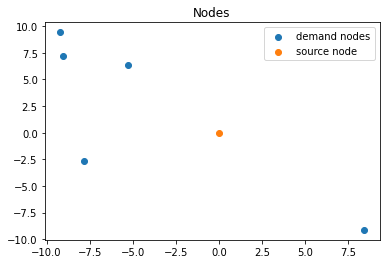

In [8]:
plot_nodes(demand_nodes, source_node)

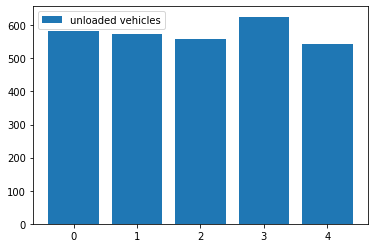

In [9]:
plot_unloads(demand_nodes)

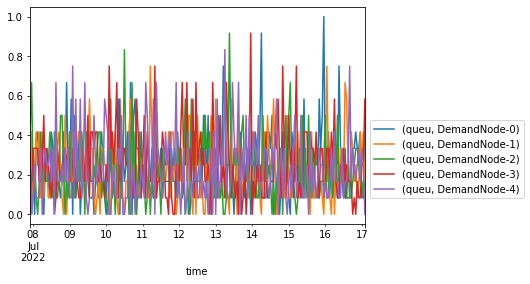

In [10]:
queus = pd.DataFrame(env.metrics['entry_queu']['values'])
queus['time'] = pd.to_datetime(queus['time'])
queus = queus[queus['node']!='SourceNode-0']
queus.pivot_table(
    index=['time'],
    columns=['node'],
    values=['queu']
).fillna(0).resample("H").mean().iloc[10:-10].plot().legend(bbox_to_anchor=(1, 0.5))

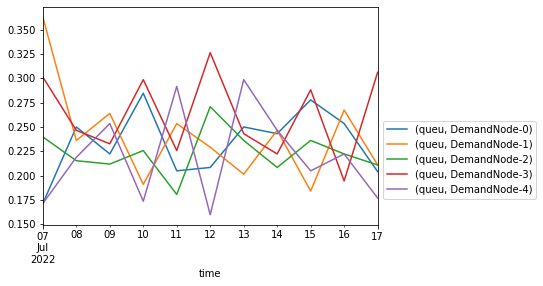

In [11]:
queus.pivot_table(
    index=['time'],
    columns=['node'],
    values=['queu']
).fillna(0).resample("D").mean().plot().legend(bbox_to_anchor=(1, 0.5))

In [12]:
queu_times = pd.DataFrame(env.metrics['queu_time']['values'])
queu_times['time'] = pd.to_datetime(queu_times['time'])
queu_times.sort_values(['vehicle','node','time']).groupby(['vehicle','node'])['time'].diff(1)
queu_times['wait_time'] = queu_times.sort_values(
    ['vehicle','node','time']
    ).groupby(
        ['vehicle','node']
    )['time'].diff(1).dt.total_seconds()

C:\Users\vitos\AppData\Local\Temp\ipykernel_20844\2924134983.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  queu_times.sort_values(['vehicle','node','time'])[


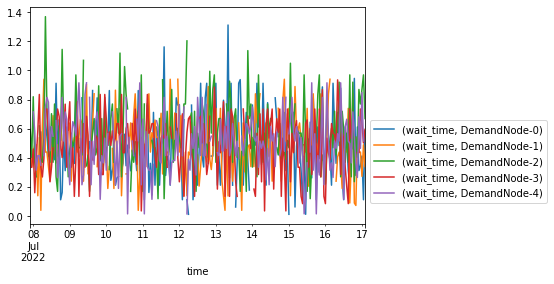

In [13]:
queu_times.sort_values(['vehicle','node','time'])[
    (queu_times['node']!="SourceNode-0")
    &
    (queu_times['action']=='exited')
].pivot_table(
    index=['time'],
    columns=['node'],
    values=['wait_time']
).resample("H").mean().iloc[10:-10].plot().legend(bbox_to_anchor=(1, 0.5))

C:\Users\vitos\AppData\Local\Temp\ipykernel_20844\3426037225.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  queu_times.sort_values(['vehicle','node','time'])[


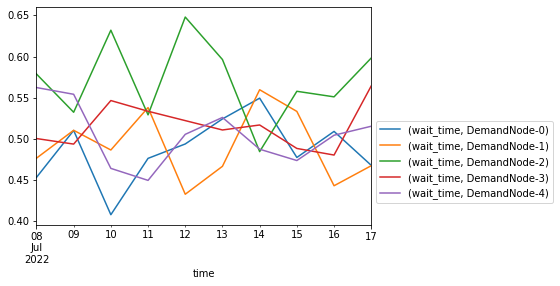

In [14]:
queu_times.sort_values(['vehicle','node','time'])[
    (queu_times['node']!="SourceNode-0")
    &
    (queu_times['action']=='exited')
].pivot_table(
    index=['time'],
    columns=['node'],
    values=['wait_time']
).resample("D").mean().iloc[1:].plot().legend(bbox_to_anchor=(1, 0.5))